In [ ]:
(* #use "topfind";; *)
(* #require "ppx_deriving";; *)
(* #require "ppx_jane";; *)
#require "yojson";;
#require "ppx_yojson_conv";;
(* #require "core";; *)
#require "async";;
#require "cohttp-async";;
#require "async_ssl";;
#require "ppx_let" ;;

#require "owl-top, jupyter.notebook";;
#require "jupyter-archimedes";;
#require "owl-jupyter";;
#require "owl-plplot";;

(* open Owl_jupyter;; *)
(* open Owl;; *)

(* #thread ;;
let () = Thread_safe.block_on_async_exn (fun () -> get_token "15011272962" "u123456A") *)

In [ ]:


module JQData : sig
  val get_token : string -> string -> string
  val get_security_info : string -> string -> string
  val get_price : string -> string -> int -> string -> string -> string
end = struct
    
    let jqapi_uri = Uri.of_string "https://dataapi.joinquant.com/apis"
    
    let get_token username password =
      let open Async in
      let open Cohttp in
      Thread_safe.block_on_async_exn (fun () ->
        let req_body = Cohttp_async.Body.of_string @@ Format.sprintf {|{"method":"get_token","mob":"%s","pwd":"%s"}|} username password in
        try_with(
            fun () -> 
            Cohttp_async.Client.post ~body:req_body jqapi_uri
            >>= fun (resp, body) ->
                Cohttp_async.Body.to_string body 
                >>| fun body -> body
        )
        >>| function
          | Ok (data)   -> data
          | Error _ -> ""
        );;
          
    let get_security_info token code =
        let open Async in
        let open Cohttp in
        Thread_safe.block_on_async_exn (fun () ->
            let req_body = Cohttp_async.Body.of_string
                @@ Format.sprintf {|{"method":"get_security_info","token":"%s","code":"%s"}|} token code in
            try_with(
                fun () -> 
                Cohttp_async.Client.post ~body:req_body jqapi_uri
                >>= fun (resp, body) ->
                    Cohttp_async.Body.to_string body 
                    >>| fun body -> body
            )
            >>| function
              | Ok (data)   -> data
              | Error _ -> ""
        );;
        
    let get_price token code count data_unit end_date = 
        let open Async in
        let open Cohttp in
(*         let req_temp = {|{"method": "get_price","token": "%s","code": "%s","count": %d,"unit": "%s","end_date": "%s"}|} in *)
(*         let req_str = Format.sprintf req_temp token code count data_unit end_date in *)
        Thread_safe.block_on_async_exn (fun () ->
(*             let req_body = Cohttp_async.Body.of_string req_str in *)
            let req_body = Cohttp_async.Body.of_string
                @@ Format.sprintf {|{"method": "get_price","token": "%s","code": "%s","count": %d,"unit": "%s","end_date": "%s"}|} token code count data_unit end_date in
            try_with(
                fun () -> 
                Cohttp_async.Client.post ~body:req_body jqapi_uri
                >>= fun (resp, body) ->
                    Cohttp_async.Body.to_string body 
                    >>| fun body -> body
            )
            >>| function
              | Ok (data)   -> data
              | Error _ -> ""
        );;
end


In [ ]:
let token = JQData.get_token "15011272962" "u123456A";;
let info = JQData.get_security_info token "502050.XSHG";;

In [ ]:

module CsvData : sig
  val df_of_csv : ?sep:char -> ?head:string array -> ?types:string array -> string -> Owl.Dataframe.t
end = struct

let str_to_elt_fun = function
  | "b" -> fun a -> Owl.Dataframe.Bool (bool_of_string a)
  | "i" -> fun a -> Owl.Dataframe.Int (int_of_string a)
  | "f" -> fun a -> if a = "" then Owl.Dataframe.Float Float.nan else Owl.Dataframe.Float (float_of_string a)
  | "s" -> fun a -> Owl.Dataframe.String a
  | _   -> failwith "str_to_elt_fun: unsupported type";;

let guess_separator lines =
  let open Owl in
  let sep = [| ','; ' '; '\t'; ';'; ':'; '|' |] in
  (* rank by dividing as many parts as possible *)
  let tmp =
    Array.map
      (fun c ->
        let l = String.split_on_char c lines.(0) in
        c, List.length l)
      sep
  in
  (* sort by decreasing order *)
  Array.sort (fun a b -> snd b - snd a) tmp;
  let sep = Array.map fst tmp in
  let not_sep = ref true in
  let sep_idx = ref 0 in
  while !not_sep = true do
    let c = sep.(!sep_idx) in
    let n = String.split_on_char c lines.(0) |> List.length in
    (try
       Array.iter
         (fun line ->
           let m = String.split_on_char c line |> List.length in
           if m <> n then raise Owl_exception.FOUND)
         lines;
       not_sep := false
     with
    | _exn -> ());
    if !not_sep = true then sep_idx := !sep_idx + 1
  done;
  (* if cannot detect, return comma as default sep *)
  if !not_sep = false then sep.(!sep_idx) else ',';;


let guess_types sep lines =
  let open Owl in
  (* Note: no need to add "s" since it is default type *)
  let typ = [| "b"; "i"; "f" |] in
  let num_lines = Array.length lines in
  (* at least two lines because the first one will be dropped *)
  assert (num_lines > 1);
  let num_cols = lines.(0) |> String.trim |> String.split_on_char sep |> List.length in
  (* split into separate columns *)
  let stacks = Array.init num_cols (fun _ -> Owl_utils_stack.make ()) in
  Array.iteri
    (fun i line ->
      if i > 0
      then
        String.trim line
        |> String.split_on_char sep
        |> List.iteri (fun i c -> Owl_utils_stack.push stacks.(i) c))
    lines;
  let cols = Array.map Owl_utils_stack.to_array stacks in
  (* guess the types of columns *)
  Array.mapi
    (fun _i col ->
      let guess_typ = ref "s" in
      (try
         Array.iter
           (fun col_typ ->
             let typ_fun = str_to_elt_fun col_typ in
             let wrong_guess = ref false in
             (try
                Array.iter
                  (fun x ->
                    let y = String.trim x in
                    typ_fun y |> ignore)
                  col
              with
             | _exn -> wrong_guess := true);
             if !wrong_guess = false
             then (
               guess_typ := col_typ;
               raise Owl_exception.FOUND))
           typ
       with
      | _exn -> ());
      !guess_typ)
    cols;;

let csv_head ?(sep = '\t') head_i lines =
(*     head_i |> ignore;; *)
    let line = lines.(0) in
    line |> String.trim |> String.split_on_char sep |> Array.of_list;;

let df_of_csv ?sep ?head ?types str =
  let open Owl in
  let lines = Array.of_list @@ String.split_on_char '\n' str in
  let count = Array.length lines in
  let sep =
    match sep with
    | Some a -> a
    | None   -> guess_separator lines
  in
  let head_i = 0 in
  let head_names =
    match head with
    | Some a -> a
    | None   -> csv_head ~sep head_i lines
  in
  let types =
    match types with
    | Some a -> a
    | None   -> guess_types sep lines
  in
  assert (Array.length head_names = Array.length types);
  let convert_f = Array.map str_to_elt_fun types in
  let dataframe = Dataframe.make head_names in
  let dropped_line = ref 0 in
  for i = head_i + 1 to count - 1 do
    try
        let lines2 = lines.(i) |> String.split_on_char sep |> Array.of_list  in
        let row = Array.map2 (fun f a -> f a) convert_f lines2 in
        Dataframe.append_row dataframe row
    with
      | _exn ->
        dropped_line := !dropped_line + 1;
        print_endline @@ Printexc.to_string _exn;
        Owl_log.warn "of_csv: fail to parse line#%i" i
  done;
  
  if !dropped_line > 0 then Owl_log.warn "%i lines have been dropped." !dropped_line;
  dataframe;;


(* let to_csv ?sep x fname =
  let m, n = shape x in
  (* include heads as the first line *)
  let csv = Array.make_matrix (m + 1) n "" in
  csv.(0) <- get_heads x;
  (* dump the data into the table *)
  for i = 0 to m - 1 do
    for j = 0 to n - 1 do
      csv.(i + 1).(j) <- elt_to_str (get x i j)
    done
  done;
  Owl_io.write_csv ?sep csv fname *)
end

In [ ]:
let token = JQData.get_token "15011272962" "u123456A"
(* let info = JQData.get_security_info  token "502050.XSHG"
let types = [| "s"; "s"; "s"; "s"; "s"; "s"; "s" |]
let df = CsvData.df_of_csv ~types info *)
let info = JQData.get_price token "502050.XSHG" 10 "1d" "2021-11-08"
let types = [| "s"; "f"; "f"; "f"; "f"; "i"; "f"; "f"; "f"; "f"; "f"; "f"; |]
let df = CsvData.df_of_csv ~types info

In [ ]:
let o = Owl.Dataframe.get df 0 1

In [ ]:
Owl_pretty.pp_dataframe Format.std_formatter df;;
flush stdout;;

In [ ]:
let open Owl.Dataframe in
df.%(0,"code") |> unpack_string |> print_endline

In [ ]:
let x = {|{"method":"get_token","mob":"%s","pwd":"%s"}|}

In [ ]:
let f = Format.sprintf

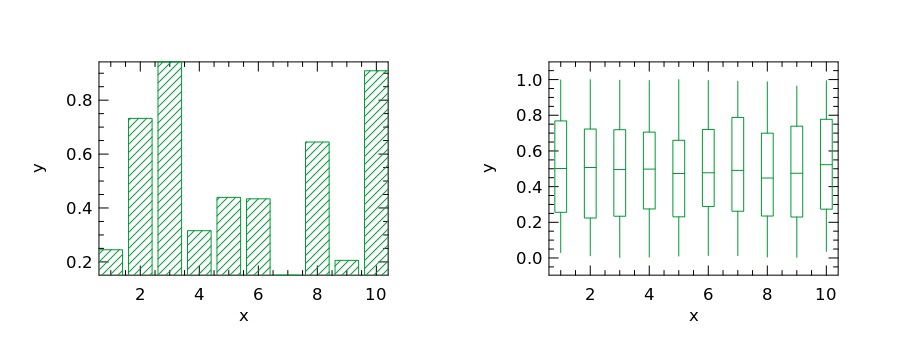

In [69]:
let open Owl in
let open Owl_plplot in
let open Owl_jupyter in

let y1 = Mat.uniform 1 10 in
let y2 = Mat.uniform 10 100 in
let h = Plot.create ~m:1 ~n:2 "plot_008.png" in
Plot.subplot h 0 0;
Plot.(bar ~h ~spec:[ RGB (0,153,51); FillPattern 3 ] y1);
Plot.subplot h 0 1;
Plot.(boxplot ~h ~spec:[ RGB (0,153,51) ] y2);
Plot.output h
;;

In [ ]:
let open Owl in
let open Owl_plplot in
let open Owl_jupyter in

  let f x = Maths.sin x /. x in
  let h = Plot.create "plot_01.png" in
  Plot.set_title h "Function: f(x) = sine x / x";
  Plot.set_xlabel h "x-axis";
  Plot.set_ylabel h "y-axis";
  Plot.set_font_size h 8.;
  Plot.set_pen_size h 3.;
  Plot.plot_fun ~h f 1. 15.;
  Plot.output h;;

In [61]:
let y1 = Owl.Mat.uniform 1 10

val y1 : Owl.Mat.mat =
  
         C0       C1       C2      C3       C4       C5       C6       C7       C8       C9 
R0 0.126228 0.764824 0.468042 0.50892 0.309411 0.243012 0.688735 0.773118 0.798177 0.726038 

